In [1]:
import pandas as pd
from numpy import *

In [2]:
import h5py

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## Loading the data 

### Load T matrix

In [3]:
f = h5py.File('./TmDataEpc.h5')

list(f.keys())

list(f['0.99Tc']['lightplightn'].keys())

ds = f['0.99Tc']['lightplightn']['Ca1']['wave0']

ds_1 = f['0.99Tc']['lightplightn']['Ca2']['wave0']

ds.shape

imT = ds[1, :, :] + 0*ds_1[1, :, :]
reT = ds[0, :, :]

erange_T = arange(0, 9.01, 0.05)
qrange_T = arange(0, 6.01, 0.05)

(0.0, 3.0)

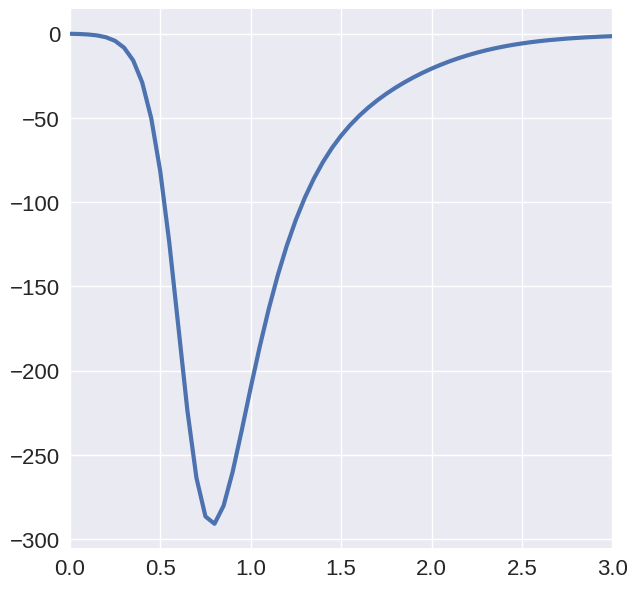

In [4]:
plt.plot(erange_T, 4*pi*imT[:, 0])

plt.xlim(0, 3)

### Load the SF

In [5]:
f_SF = h5py.File('./SF.h5')

list(f_SF.keys())

['lightp']

In [6]:
ds_SF = f_SF['lightp']
ds_SF.shape

(7381, 3)

In [7]:
ds_SF[0], ds_SF[1], ds_SF[2]

(array([-1.        ,  0.        , -0.00372613]),
 array([-0.95      ,  0.        , -0.00442894]),
 array([-0.9       ,  0.        , -0.00321106]))

In [8]:
len(arange(-1, 5.01, 0.05)), len(arange(0, 3.01, 0.05))

(121, 61)

In [9]:
df_Q = []

for i in range(121):
    df_Q += [ds_SF[i::121]]
    
df_Q = array(df_Q)

In [10]:
df_vals = zeros([121, 61])

In [11]:
for i in range(121):
    for j in range(61):
        df_vals[i, j] = df_Q[i, j, -1]

In [12]:
erange_SF = arange(-1, 5.01, 0.05)
qrange_SF = arange(0, 3.01, 0.05)

In [13]:
qrange_SF[20]

1.0

(-1.0, 2.0)

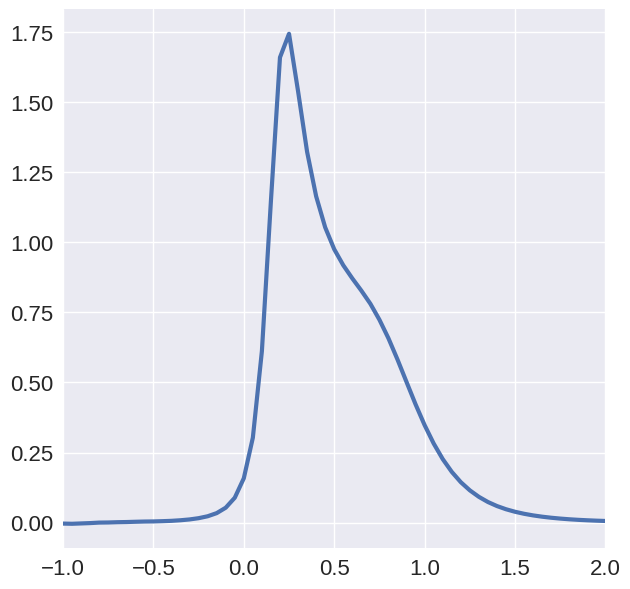

In [14]:
plt.plot(erange_SF, df_vals[:, 0])

plt.xlim(-1, 2)

In [15]:
df_Q = array(df_Q)

In [16]:
df_Q.shape

(121, 61, 3)

### Import the self-energy

In [17]:
f_SE = h5py.File('./SelfE_single.h5')

list(f_SE.keys())

['lightp']

In [18]:
ds_SE = f_SE['lightp']

In [19]:
ds_Im = ds_SE[1, :, :]

In [20]:
df_Im = []

for i in range(121):
    df_Im += [ds_Im[i::121]]
    
df_Im = array(df_Im)

df_Im_vals = zeros([121, 61])

for i in range(121):
    for j in range(61):
        df_Im_vals[i, j] = df_Im[i, j, -1]

In [21]:
ds_Re = ds_SE[0, :, :]

df_Re = []

for i in range(121):
    df_Re += [ds_Re[i::121]]
    
df_Re = array(df_Re)

df_Re_vals = zeros([121, 61])

for i in range(121):
    for j in range(61):
        df_Re_vals[i, j] = df_Re[i, j, -1]

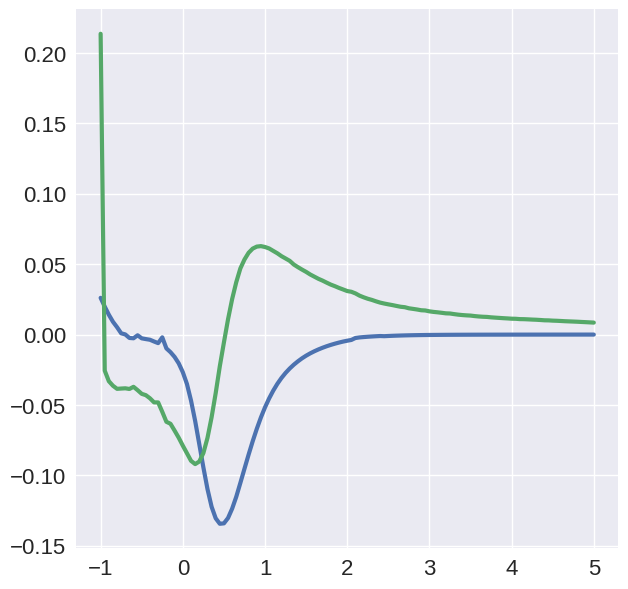

In [22]:
plt.plot(erange_SF, df_Im_vals[:, 0])
plt.plot(erange_SF, df_Re_vals[:, 0])

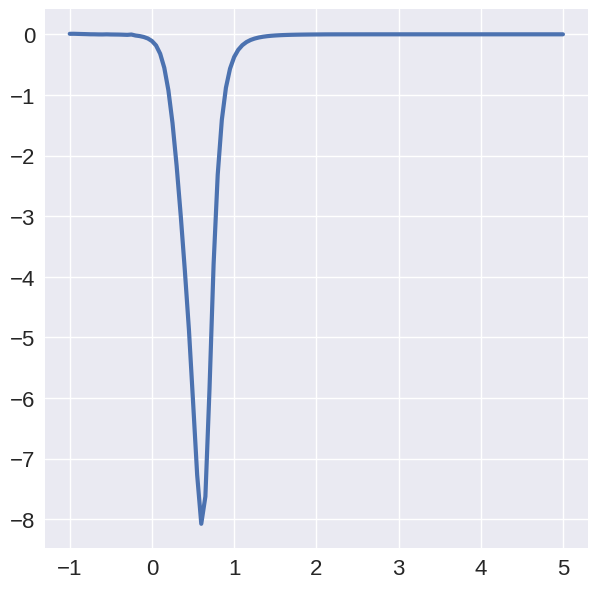

In [23]:
plt.plot(erange_SF, imag(1/(erange_SF - 0.57 - (df_Re_vals[:, 0] + 1j * df_Im_vals[:, 0]))))

# Run the calculation

In [24]:
import TMQGP as tm

In [25]:
iImT = tm.Interpolator2D(qrange_T, erange_T, imT)
iReT = tm.Interpolator2D(qrange_T, erange_T, reT)

In [26]:
iRho = tm.Interpolator2D(qrange_SF, erange_SF, df_vals)

In [27]:
res = array([tm.sigma_ff(e, 0, 0.194, iImT, iRho) for e in erange_SF])
# res = array([tm.E_integral(e, 0, 0.194, iImT, iRho) for e in erange_SF])

In [28]:
eps1 = tm.Interpolator(qrange_SF, sqrt(0.57**2 + qrange_SF**2), 'linear')
eps2 = tm.Interpolator(qrange_SF, sqrt(0.57**2 + qrange_SF**2), 'linear')

In [29]:
erange = linspace(-5, 5, 200)

In [30]:
res_onshell = array([tm.sigma_ff_onshell(e, 0, 0.194, iImT, iRho,
                                        eps1, eps2)
                     for e in erange])

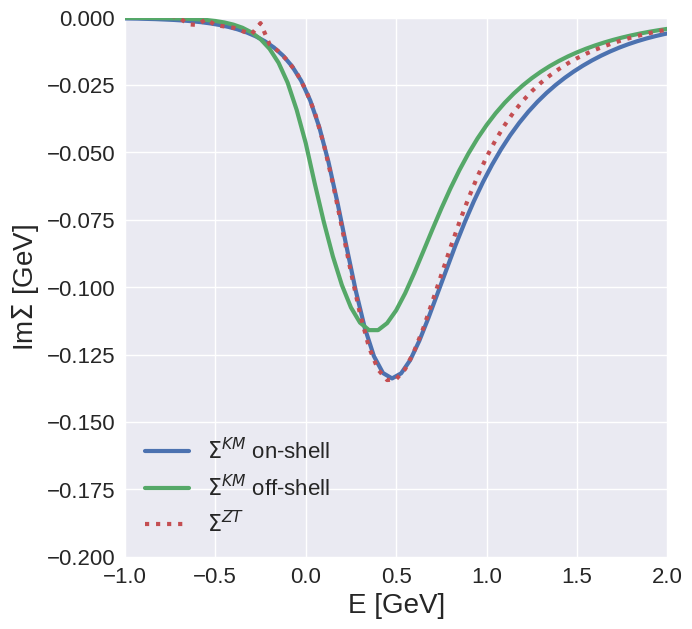

In [31]:
# plt.plot(erange_SF, 2*4*pi*2*pi*res/6*4, label=r'$(4\pi)(2\pi) \Sigma^{KM}$', ls='--')
plt.plot(erange, 3*4*pi*res_onshell/6*4, label=r'$\Sigma^{KM}$ on-shell')
plt.plot(erange_SF, 3*4*pi*res/6*4, label=r'$\Sigma^{KM}$ off-shell')
plt.plot(erange_SF, df_Im_vals[:, 0], ls=':', label=r'$\Sigma^{ZT}$')
plt.legend()

plt.xlabel('E [GeV]')
plt.ylabel(r'Im$\Sigma$ [GeV]')

plt.xlim(-1, 2)
plt.ylim( -0.2, 0)
plt.savefig('sigma_ff_compare_3x.pdf', bbox_inches='tight')

In [70]:
quad(lambda z: iRho(0, z), -1, 3)

NameError: name 'quad' is not defined